In [539]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!export CUDA_VISIBLE_DEVICES=1

In [3]:
from gen_images import *
import mmcv
from avcv.visualize import *
from avcv.utils import *
# from projector import project

In [ ]:
# def expand_seed(seeds, vector_size):
#     result = []

#     for seed in seeds:
#     rnd = np.random.RandomState(seed)
#     result.append( rnd.randn(1, vector_size) ) 
#     return result


In [554]:
network_pkl = 'training-runs/00015-stylegan2-gtsr_64_dest-gpus8-batch128-gamma8.2/network-snapshot-025000.pkl'

device = torch.device('cuda:1')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [555]:
seeds = [0,1,2,3]
outdir = '.cache/00/'
truncation_psi = 1
# !mkdir -p {outdir}
mmcv.mkdir_or_exist(outdir)
noise_mode = 'const'

In [556]:
def forward_w(z, c, truncation_psi=1, truncation_cutoff=None, update_emas=False, **synthesis_kwargs):
    ws = G.mapping(z, c, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, update_emas=update_emas)
    return ws

def forward_img(ws, synthesis_kwargs=dict(), to_np=True):
    img = G.synthesis(ws, update_emas=False, **synthesis_kwargs)
    if to_np:
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    return img

In [557]:
# Generate images
@torch.no_grad()
def gen_z(seed, trunc=None):
    
    z = np.random.RandomState(seed).randn(1, G.z_dim)
    if trunc is not None:
        z = np.clip(z, -trunc, trunc)
    
    return torch.from_numpy(z).to(device)
@torch.no_grad()
def gen_img(z, cls_id):
    label = torch.zeros([1, G.c_dim], device=device)
    label[:, cls_id] = 1
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    return img
@torch.no_grad()
def gen_W(z, cls_id):
    label = torch.zeros([1, G.c_dim], device=device)
    label[:, cls_id] = 1
    W = G.mapping(z, label,  truncation_psi=truncation_psi)
    return W, label

In [558]:
from tqdm import tqdm
@torch.no_grad()
def gen_in_between(z1, z2,num_in_between=100):
    imgs = []

    delta = (z2-z1)/num_in_between
    for i in tqdm(range(num_in_between)):
        z = z1+i*delta
        img = gen_img(z)
        imgs.append(img[...,::-1])
    return imgs
@torch.no_grad()
def gen_with_direction(z1, delta, num):
    imgs = []
    for i in tqdm(range(-num//2, num//2)):
        z = z1+i*delta
        img = gen_img(z)
        imgs.append(img[...,::-1])
    return imgs


In [559]:
Ws = []
targets = []

for seed in range(100):
    z = gen_z(seed)
    cls_id = np.random.choice(3)
    W = gen_W(z, cls_id)[0]
    Ws.append(W)
    targets.append(cls_id)

Ws = torch.stack(Ws)

In [560]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

In [561]:
pca = PCA(n_components=5)

In [562]:
x = Ws.mean([1,2])
x = x.cpu().numpy()

In [563]:
principalComponents = pca.fit_transform(x)

In [564]:
principalComponents[:,0].max()

24.188417

In [565]:
# Ws.shape

In [567]:
!mkdir -p mp4

In [570]:
w_inverse.shape

(512,)

In [571]:
w_inverse = torch.from_numpy(w_inverse)

In [575]:
new_w = w


In [577]:
new_

torch.Size([512])

In [584]:
new_w.

torch.Size([512])

In [585]:
n_steps = 100
for i in range(5):
    delta = (principalComponents[:,i].max()-principalComponents[:,i].min())/n_steps
    imgs = []
    for step in range(n_steps):
        w = Ws[0, 0, 0]
        w_reduction = pca.transform(w.cpu().numpy()[None])
        w_reduction[:,i] = principalComponents[1, :].min()+step*delta
        w_inverse = pca.inverse_transform(w_reduction)[0]
        new_w = Ws[0]
        w_inverse = torch.from_numpy(w_inverse)
        new_w[0,0] = w_inverse
        # new_w = torch.stack([torch.from_numpy(w_inverse)]*10, 0)[None].to(device)
        img = forward_img(new_w)
        imgs.append(img[...,::-1])
    images_to_video(imgs, f'mp4/{i}.mp4')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 725.4 task/s, elapsed: 0s, ETA:     0s

2021-12-22 05:58:51.255 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-22 05:58:51.256 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:51.257 | INFO     | avcv.utils:images_to_video:159 - out_path: mp4/0.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 673.5 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:53.486 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-22 05:58:53.487 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:53.489 | INFO     | avcv.utils:images_to_video:159 - out_path: mp4/1.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 599.4 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:55.636 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-22 05:58:55.637 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:55.642 | INFO     | avcv.utils:images_to_video:159 - out_path: mp4/2.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 901.1 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:57.706 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-22 05:58:57.707 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:57.708 | INFO     | avcv.utils:images_to_video:159 - out_path: mp4/3.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 854.0 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:59.779 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-22 05:58:59.780 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-22 05:58:59.782 | INFO     | avcv.utils:images_to_video:159 - out_path: mp4/4.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 700.1 task/s, elapsed: 0s, ETA:     0s

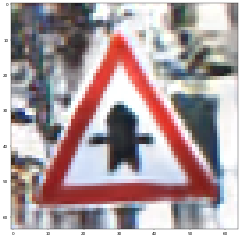

In [553]:
show(gen_img(gen_z(3), 11), dpi=30)